# Google Colab上のRで遺伝子発現解析
遺伝子発現を全遺伝子で調べられるマイクロアレイデータを例に、遺伝子発現データをR言語で処理してみて、発現に差のある遺伝子をピックアップし、（外部のエンリッチメント解析ウェブサービスを利用して）生物学的に解釈するというのをやってみた。
（あくまでRの勉強用なので、一部 簡略化しているところがある）
（参考までに同じことをRStudioでやった版や、Excelでやった「Excelでなぞる遺伝子発現解析」もあります）

## Google Colaboratoryでの利用について
このファイルを自分のGoogle　Colaboratory （Google Colab） で開くと編集なりができるようになるはずです。作ったファイルは自分のGoogle　Driveに保存されます。
右上にGoogleアカウントのアイコンが出ているはずです。（私も含めて）複数のGoogleアカウントを持っていると、えてして別のアカウントでGoogle　Colabが開かれたりしていまいますので、保存されるファイルもそのアカウントのGoogle　Driveに保存されます。ファイルを行方不明にしないように。。。

## 背景
### 今回 利用するデータ
- GSE18226 ：Expression data from human iPS cells and fibroblasts （ヒトiPS細胞と皮膚細胞からの遺伝子発現データ） https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE18226
- 今回はこれを加工したデータを用いる ([GSE18226.for_exercise.slim.tsv](https://raw.githubusercontent.com/chalkless/lecture/master/biostats/exp/GSE18226.for_exercise.slim.tsv))。あらかじめダウンロードしておく。（右クリックして「名前をつけて保存」）


### 生物学的背景
- 多細胞生物は、受精卵から細胞分裂して、人間であれば血球、神経、皮膚などなどさまざまな細胞に特化していく。この特化のことを分化という。
分化は不可逆的で、動物の場合は一般的には血球や皮膚などに分化した細胞から、未分化状態には戻れない。（植物の場合は、薬品処理をしたりするなどすると戻れる）
- 今回は分化した皮膚細胞と、未分化状態に戻したiPS細胞で遺伝子の発現状況を比較して、皮膚の状態のみ、iPS細胞の状態のみで発現している（＝働く）遺伝子はどういう機能があるのか、というのを確認する。
- 京大・山中先生がノーベル賞をとったiPS細胞の話（成熟した細胞の多能性を持つ細胞への初期化）の追加実験と思えば良い（グループは違うが）元データは https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE18226 からダウンロードできる。が、次に述べる加工は必要）

### 解析の目標
- ヒトの皮膚細胞とiPS細胞でどんな機能の遺伝子が特異的に（=その状態のみで）働いているか?（または働いていないか?）


## 遺伝子発現データの統計的な解析

### ファイルを開く
* まずこのファイルをGoogle　Colabで見られるようにするのが第一歩です。。。
* 改めてだが、今回はGEOから取得したデータを加工した ([GSE18226.for_exercise.slim.tsv](https://raw.githubusercontent.com/chalkless/lecture/master/biostats/exp/GSE18226.for_exercise.slim.tsv)を使って説明する。（ので右クリックでダウンロードしておく。拡張子がtxtファイルのファイルの場合もあるのであとで呼び出す際にファイル名を合わせて変更すること）
* データをアップロードする。
* 画面左のフォルダマークをクリックすると、ファイルの一覧が表示されるので、そこに自分のマシンからファイルをドラッグアンドドロップするか、ファイルと書かれた次の行の一番左（紙に↑マーク。マウスオーバーするとセッションストレージにアップロードと出る）をクリックしてファイルを選択し、データのファイルをこのファイルから見えるようにする。
*　その際、ランタイムが切れた時にファイルも消えてしまう旨、表示が出るがしかたないのであきらめる。
* 実際、しばらくアクセスしないとファイルが消えてしまうので、つどつどアップする。
*　Google　Driveを見えるようにすればいいのだが、その方法はここではややこしいので扱わない。詳しくは[Google ColabでRを使いDriveにアクセスする](https://mana.bi/wiki.cgi?page=Google+Colab%A4%C7R%A4%F2%BB%C8%A4%A4Drive%A4%CB%A5%A2%A5%AF%A5%BB%A5%B9%A4%B9%A4%EB)

* データの方は、今回はタブ区切り（tsv: tab separated value）ファイル。
*　次のようにして読み込む
  *  file_use　でファイル名を記載（今回はtxtとtsvと名前違いで配布しているため、自分のファイルに合わせて書き換えること）
  * read.table関数でfile_useを読み込む。ヘッダがあるとか、データに対するラベルがついているかどうかの指定もしている
  * Windowsでいうところのメモ帳で開くような（専門的にはエディターと呼ばれるソフトで開くような。人間の読める）ファイルをテキストファイルというが、Rで扱うようなファイルにはタブ区切りの他にCSVファイル（カンマ区切り：comma separated value）がある。その場合、sep（区切り文字）を\tでなく , にするか、read.tableでなくread.csvを用いる。
  * header は、1行目に列ラベルがついているかどうか。ついていればTRUE、ついていなければFALSE
  * row.names = 1: 1列目をデータでなく、行の名前として用いる（これを指定しないと、Rが勝手に1から行の名前を振っていって、この場合、プローブIDもデータとして扱われる）



In [1]:
file_use <- "GSE18226.for_exercise.slim.tsv"
data <- read.table(file_use, header = TRUE, row.names = 1, sep = "\t")


再生ボタンを押すなり、⌘+Enter（Mac）、Ctrl+Enter (Win)
すると実行されるが、特に何も起きない。
実際にデータが読み込まれたか、データの頭の方をちょっと見てみる。

In [2]:
head(data)

,fibroblast1,fibroblast2,iPS1,iPS2
,<dbl>,<dbl>,<dbl>,<dbl>
1007_s_at,756.91388,460.02260,1792.93290,2154.69857
1053_at,525.54751,516.69150,804.51230,1042.74867
117_at,38.58140,38.79062,28.08664,40.90642
121_at,67.27947,76.39873,47.69220,63.89045
1255_g_at,17.32354,11.44902,922.19479,724.77923
1294_at,214.88953,241.32176,43.02899,59.87467


* 今回はID_REF（プローブ名）, fibroblast1, fibroblast2, iPS1, iPS2 というデータ構成になっている。

### データの分布を調べてみる
- データの列には遺伝子の発現量が数値で入っている
  - GEOに登録してあるのは対数値なのですが、行に対して計算をする（今回は対数をとる）演習と、あとで平均をとるので今回はわざわざ数値を元に戻しています（なので、先ほどGEOからとってきたファイルと中身が違います）
- ちらちら眺めると0に近い値から数千まで数値があるような
- そこで、各列で最大値を計算してみましょう。
  - 今回の場合、各列について計算をしてみます

In [3]:
max(data$fibroblast1)
max(data$fibroblast2)
max(data$iPS1)
max(data$iPS2)

[1] 25137.1

[1] 24833.19

[1] 24926.15

[1] 24416.99

- このように各列全体をさすには「データ名$列名」のようにします。
- 同様にして最小値（min）、平均値（mean）、中央値（median）も計算すれば良いのですが、Rの場合、表全体に対してまとめて各列の統計を出す関数が用意されているのでそれを使いましょう。

In [4]:
summary(data)

  fibroblast1         fibroblast2             iPS1          
 Min.   :    4.657   Min.   :    4.861   Min.   :    4.563  
 1st Qu.:   19.995   1st Qu.:   19.983   1st Qu.:   20.050  
 Median :   55.981   Median :   54.737   Median :   60.098  
 Mean   :  541.334   Mean   :  537.980   Mean   :  513.680  
 3rd Qu.:  372.962   3rd Qu.:  382.394   3rd Qu.:  366.227  
 Max.   :25137.102   Max.   :24833.195   Max.   :24926.151  
      iPS2          
 Min.   :    4.527  
 1st Qu.:   19.941  
 Median :   58.095  
 Mean   :  528.631  
 3rd Qu.:  370.027  
 Max.   :24416.986  

- 暫定的な考察：左2列がfibroblast、右2列がiPS。これからその2列どうしの数値の平均をとるが、特に中央値や平均値が大きくずれていないので、2列のデータの分布はほぼ同じそうだと期待でき、特に補正（正規化という）をせずに先に進むこととする。（というか実際はすでに補正済のデータが登録されていたのだろう）
- Rの場合、本当にずれていないかどうかをすぐに可視化できるので、fibroblast1/fibroblast2の各分布（ヒストグラム）、fibroblast1 vs fibroblast1、fibroblast1　vs iPS1の散布図を描いて確認してみましょう。
* 見やすくするためにヒストグラムをとる時に対数をとっています。

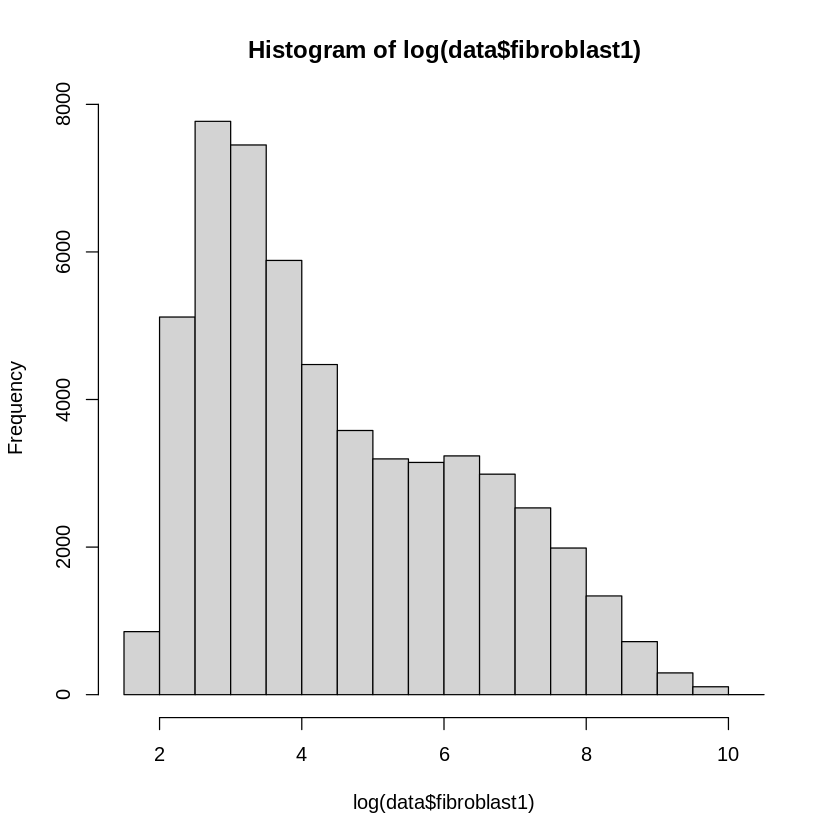

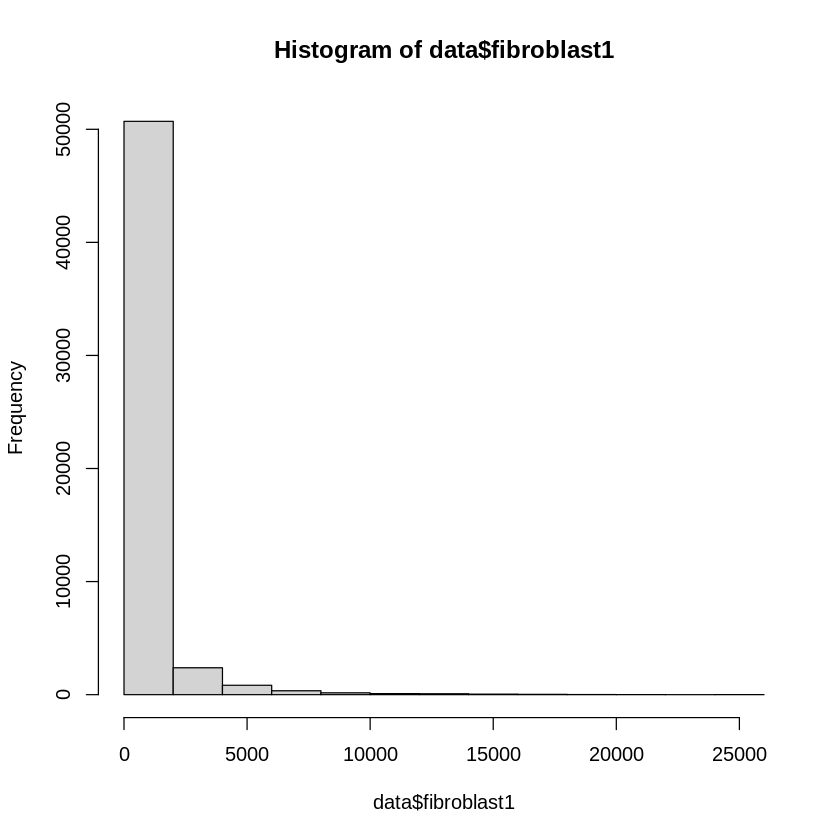

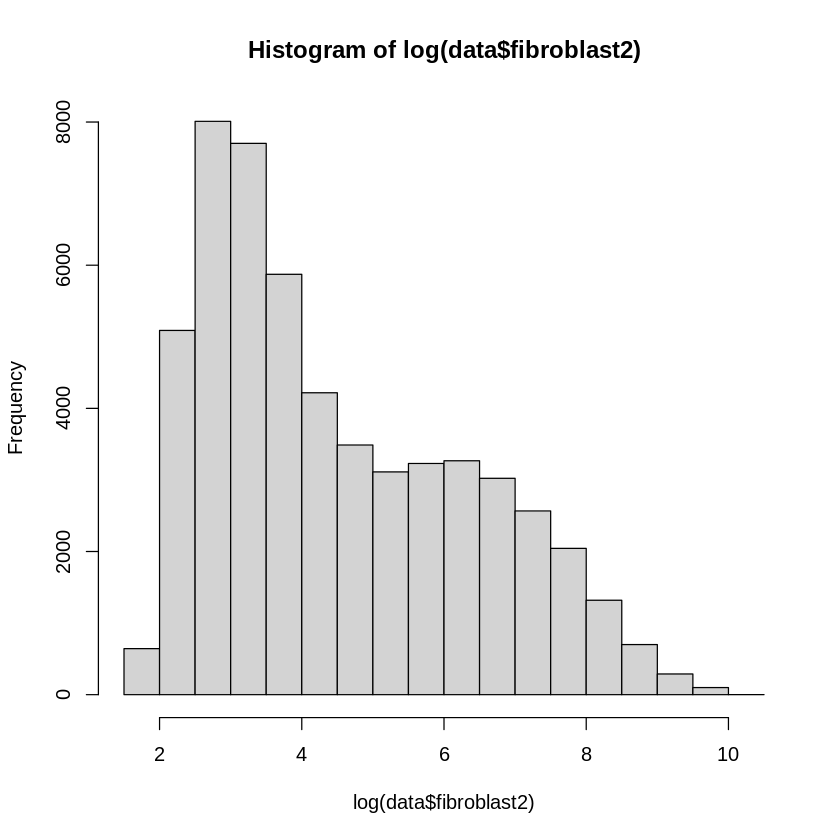

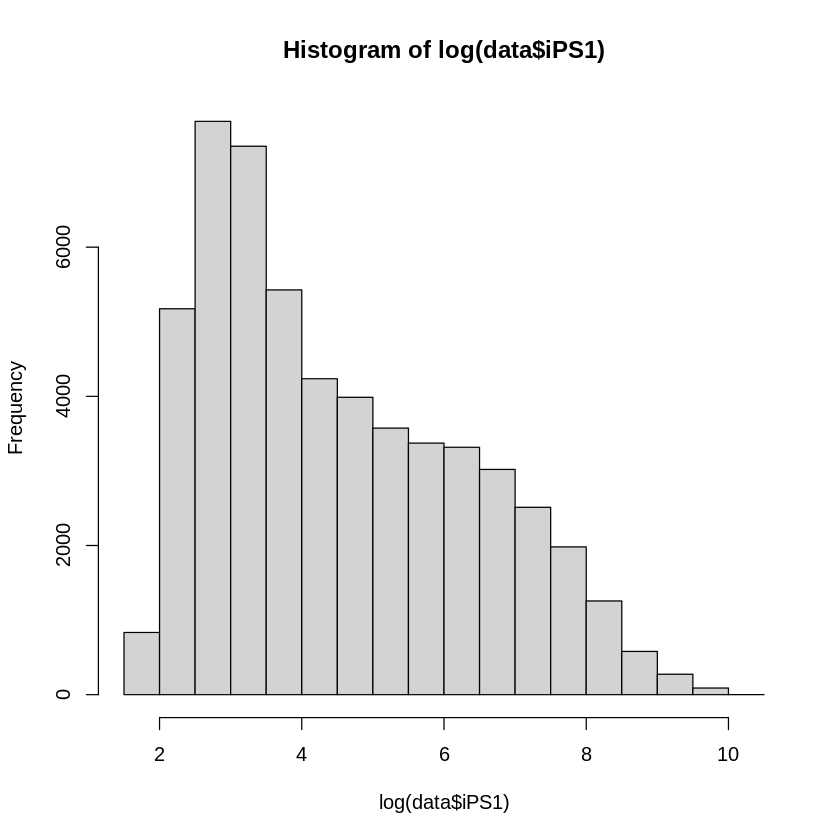

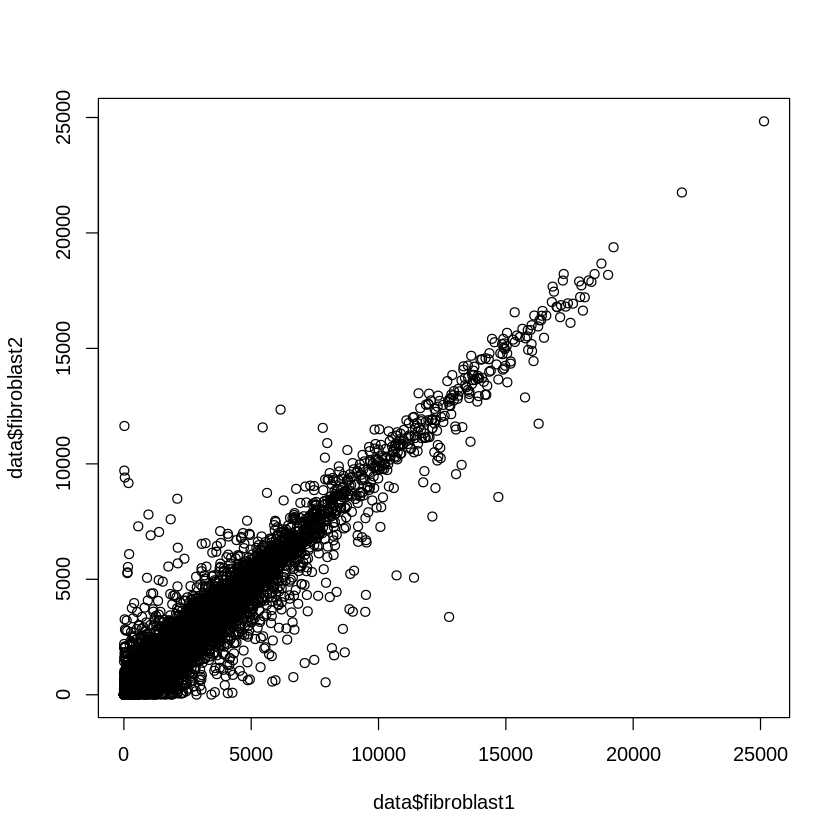

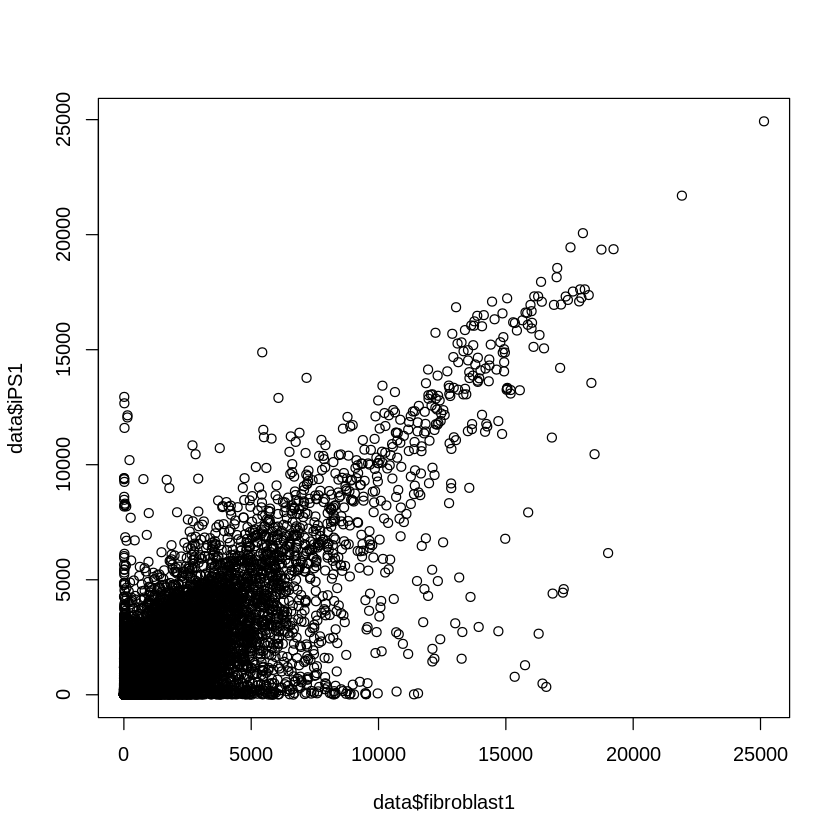

In [5]:
hist(log(data$fibroblast1))
hist(data$fibroblast1)
hist(log(data$fibroblast2))
hist(log(data$iPS1))
plot(data$fibroblast1, data$fibroblast2)
plot(data$fibroblast1, data$iPS1)

* わかること
  * ヒストグラムを見るに、同じ形なので処理（=正規化）せずに演算や比較をして良さそう
  *　散布図を見るに、fibroblastどうしだとデータがほぼ一直線上なので誤差は少なそう。
  *　一方で、fibroblastとiPSの散布図は（fibroblastどうしなどよりは）データが散っているのでだいぶ遺伝子発現が変動していそう（個々のデータの分布は似ているが）

### 2つの状態での発現量を比較する
- 左2列のfibroblast、右2列のiPSをそれぞれ2回実験をしたとみなして、誤差を補正するために平均をとることとする。

In [7]:
data$ave_fibroblast <- rowMeans(data[,1:2])
data$ave_iPS <- rowMeans(data[,3:4])

例によって実行しても特に何もなかったかのように振る舞いますが、データの中身を見ると行ごとに平均をとった列が増えています。

In [8]:
head(data)

,fibroblast1,fibroblast2,iPS1,iPS2,ave_fibroblast,ave_iPS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1007_s_at,756.91388,460.02260,1792.93290,2154.69857,608.46824,1973.81573
1053_at,525.54751,516.69150,804.51230,1042.74867,521.11950,923.63049
117_at,38.58140,38.79062,28.08664,40.90642,38.68601,34.49653
121_at,67.27947,76.39873,47.69220,63.89045,71.83910,55.79133
1255_g_at,17.32354,11.44902,922.19479,724.77923,14.38628,823.48701
1294_at,214.88953,241.32176,43.02899,59.87467,228.10564,51.45183


  - ```data$ave_fibroblast <- ...``` のようにすることによって、表に1列足す形で結果を追加している。
  - 本当はrowMeansは行列全体で行ごとの和を出すものなので、行列名（データ名）を引数に渡せばいいのだが、今回は2タイプが混じっているのでこのようにしている。
  - [, 1:2] の部分は列番号（この場合、1列目から2列目まで）。もしかして列番号でなくて列名（fibroblast1など）で指定ができるかもしれないが、見つけきれなかったのでこうしている。

- 同様に計算した平均に対して対数をとる。
- 別に底は2でも10でもいいのだが、マイクロアレイの解析の時は、伝統的に「発現比2倍以上」というデータの絞り込みをしていたため、わかりやすくするために底は2を用いている。（というか、そういうこともわかりやすくするために対数をとるのである）

In [9]:
data$log_fibroblast <- log2(data$ave_fibroblast)
data$log_iPS <- log2(data$ave_iPS)

- 発現比を計算する。
- **今回やりたいのは、元のデータが何倍の発現量差があるかなので、対数の比をとるのでなく、比をとった後で対数をとる**
  - 覚えていますか：log(A/B) = log(A) - log(B)

In [10]:
data$diff <- data$log_fibroblast - data$log_iPS

### 発現量比較のデータを眺めてみる
- diff 列のデータの意味を振り返ってみる
  - `diff = 2` ：log(diff)=2 だから2^2で4倍の発現差がある。この場合、leafの発現が高い
  - `diff = -2`：log(diff)=-2 だから1/(2^2)で1/4倍の発現差がある。この場合、leafの発現が1/4だから、protoplastの方が4倍発現が高い
  - `diff = 0`：log(diff)=0 ということ。つまり、2^0=1。ようするに、leafとprotoplastで発現量が同じということ
- 試しに diff 列について、`max`, `min`, `mean`, `median` を計算してみる

In [11]:
summary(data$diff)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-10.012133  -0.510412   0.069186   0.006346   0.475885   9.513392 

- 特にaverage、medianはほぼ0のはず。（というか、元の分布がそうなるようにすでに補正してあるわけである）
- 実際のデータの分布がどんなかヒストグラムを描いて確認してみる

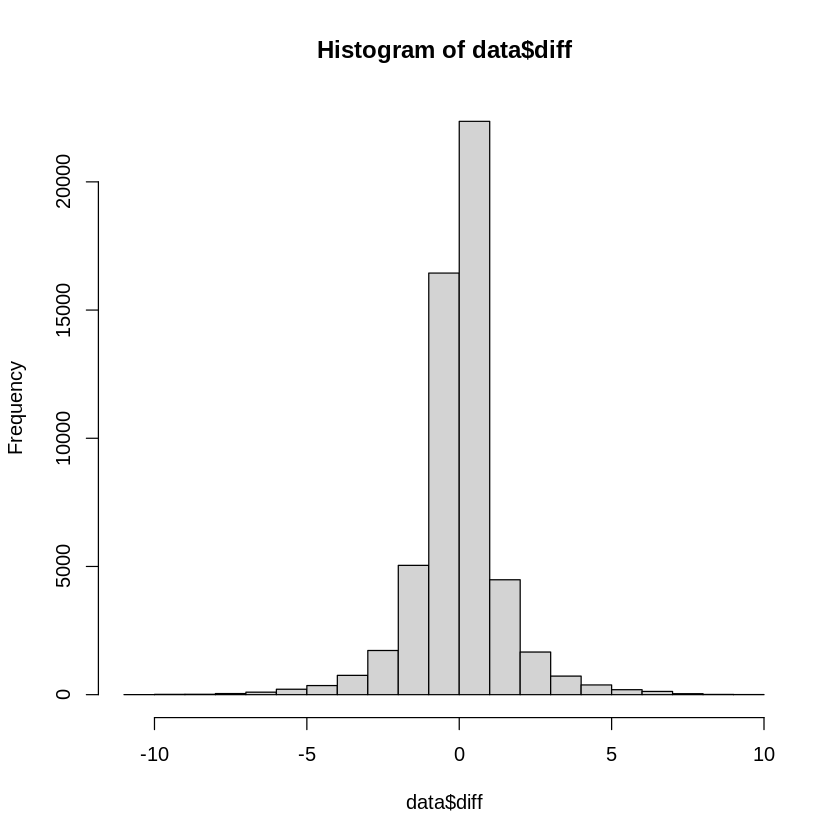

In [12]:
hist(data$diff)

- ちょっとグラフが荒いので、もう少し柱の幅を小さくしてみる

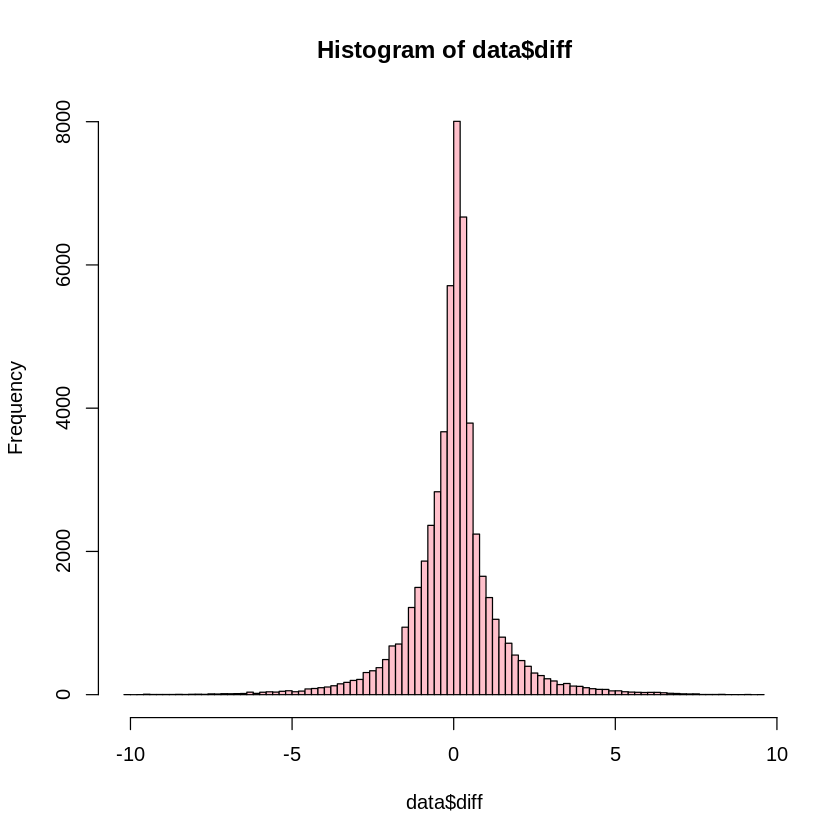

In [13]:
hist(data$diff, breaks = 120, col = "pink")

- hist関数でヒストグラムが描画される
  - 0 を中心に左右対称になっている
  - breaks の数は柱を何本立てるかを指定していると思ってください。
- 実際のデータで分布がどうなっているかも散布図 (scatter plot) で確認することとする

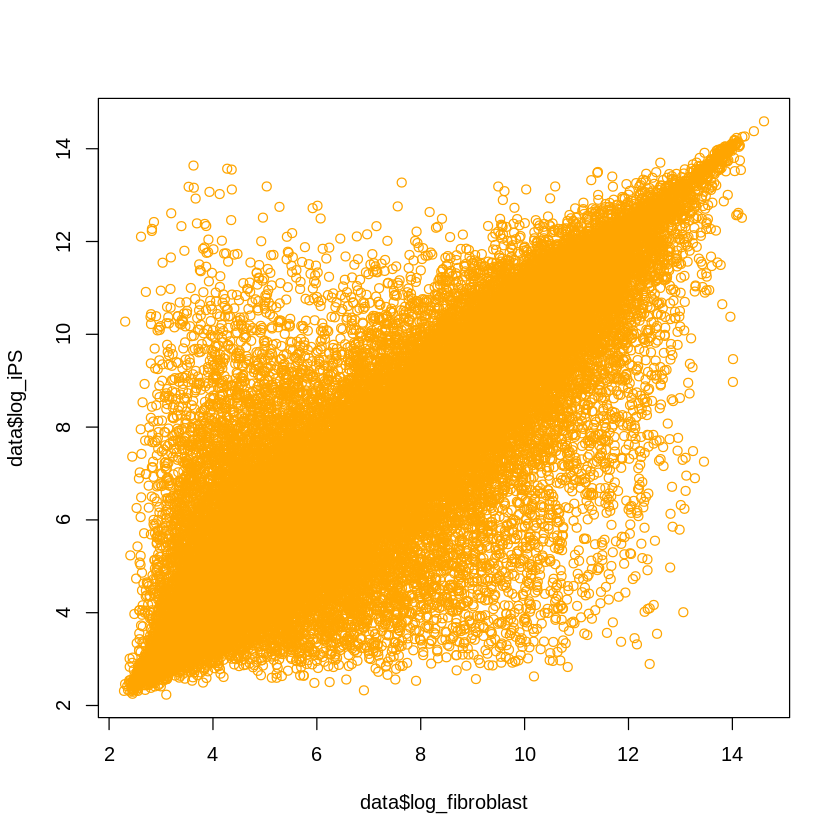

In [14]:
plot(data$log_fibroblast, data$log_iPS, col = "orange")

- fibroblastとiPSで発現変化がないと、log(fibroblast)=log(iPS)、つまりy＝x の上に載りますということ。上のグラフに追加することもできる。


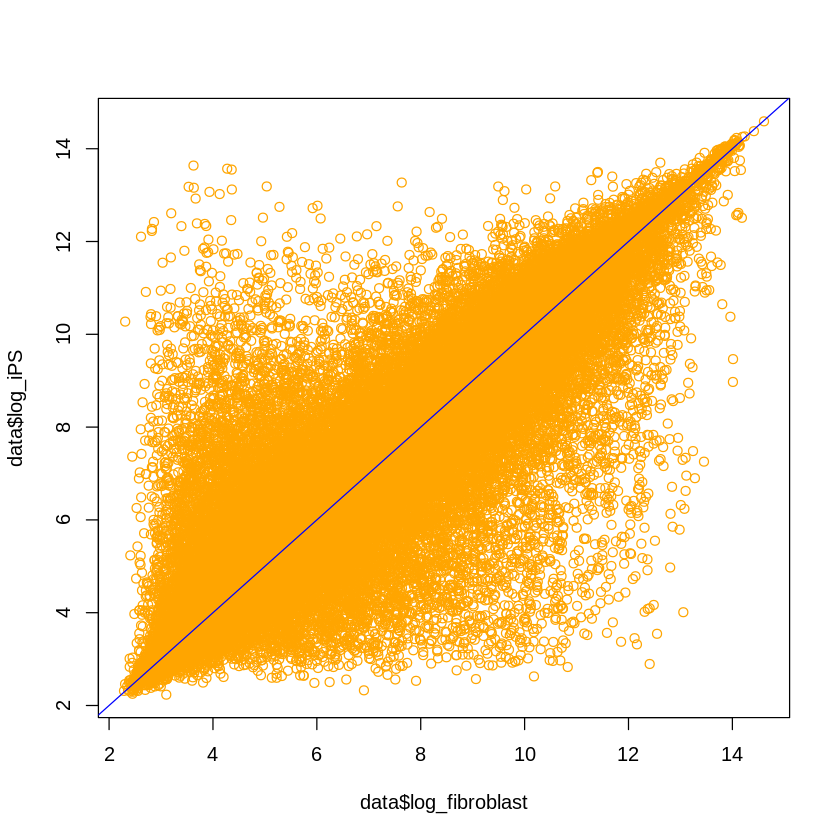

In [15]:
plot(data$log_fibroblast, data$log_iPS, col = "orange")
abline(0,1, col = "blue")

- abline(b, a) は、y=ax+b を描画している
  - 普通はablineの中で、add = "T" を記載してグラフを重ね合わせるのだが、中にはablineのように（えてして単純な）グラフは何も指定しないと直前のグラフエリアに描画されるようになっている。
- 散布図 (scatter plot) を眺めてみる
  - 青線から離れるほど、発現が変わっている
  - 下に離れるとfibroblastで発現が大きい、上に離れるとiPSで大きい

## 発現に差のある遺伝子の機能解析
- **覚えていますか**：[解析の目標] ヒトの皮膚細胞とiPS細胞でどんな機能の遺伝子が特異的に（=その状態のみで）働いているか?（または働いていないか?）


### 発現に差のあるデータの絞り込み
- fibroblastで発現の高い遺伝子のみを抽出してみる。今回は試しに8倍以上にしてみる
  - 8 という数字は適当です。
  - 適当というのは、まぁ、こんなもんかな、ってことです。
  - どうしてまぁ、こんなもんかなって思うかは、試しに絞り込んでみて、（全体が20000くらいに対して）いくつくらいに絞り込めるかとか、結果を見てみたらきれいになったとか、信頼度がどのくらいかとか、そういうので決めているだけで、統計的にかっちり基準があるわけではありません。
  - またあとでこのあたりは出てきます
- 今回は8倍以上なのでlog2をとって3以上にしている

In [16]:
data_x3 <- data[data$diff>=3,]
nrow(data_x3)
# head(data_x3)

[1] 1473

- nrowで行数をカウントしている。この場合、1473行のデータがあるわけだ。
  - ちょっと多いなぁ。。。
  - というわけで、対数で5（実データで32倍）くらいにしてみる
- 対数で5以上にしてみる。

In [17]:
data_x5 <- data[data$diff>=5,]
nrow(data_x5)

[1] 369

- 369個になった。
- まだ多い

In [18]:
data_x8 <- data[data$diff>=8,]
nrow(data_x8)

[1] 12

対数で8（実データで256以上）にしたら12で絞り込みすぎた


In [23]:
data_x7 <- data[data$diff>=7,]
nrow(data_x7)

[1] 49

対数で7以上（実データで128以上）にしたら49なのでこのくらいか。。。

- さきほどの散布図で、対数で5以上の遺伝子の色だけ変えることもできる

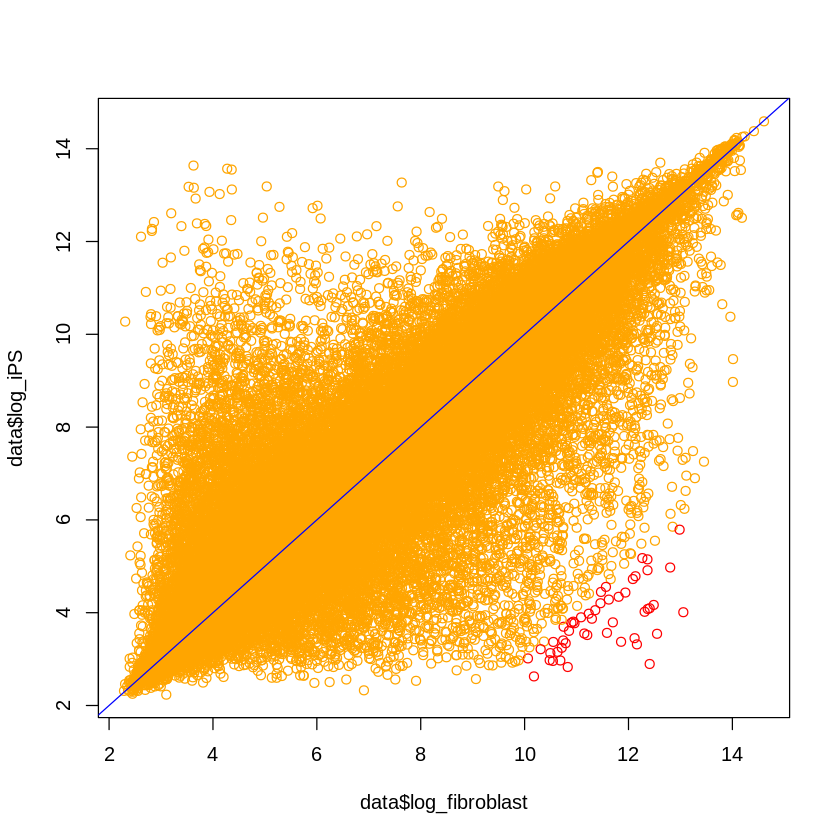

In [24]:
plot(data$log_fibroblast, data$log_iPS, col = ifelse(data$diff>=7, "red", "orange"))
abline(0,1, col = "blue")

- 結果をファイルに出力してしまいましょう。

In [70]:
file_rslt <- "GSE18226.up_7.txt"
genelist_probeid <- rownames(data_x6)
write(genelist_probeid, file_rslt)

-　左のファイルリストに出力したファイルが現れます。出てこない場合は、ファイルと書かれた次の行のアイコンのうち真ん中（フォルダーに丸い矢印マーク）をクリックすると出てきます。

In [26]:
head(rownames(data_x7))

[1] "1554997_a_at" "1555673_at"   "1555778_a_at" "201893_x_at"  "203939_at"   
[6] "204298_s_at"

## データの生物学的な解釈

-　ここから先は試行錯誤中なのでいろいろ書き換えます。。。(21/6/25)
- 今回のプラットフォームはHG-U133_Plus_2 (Affymetrix Human Genome U133 Plus 2.0 Array)


In [29]:
BiocManager::install("hgu133plus2.db")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Installing package(s) 'hgu133plus2.db'

also installing the dependency ‘org.Hs.eg.db’


Old packages: 'broom', 'colorspace', 'curl', 'dplyr', 'gert', 'ggplot2',
  'mime', 'openssl', 'rmarkdown', 'testthat', 'xfun'



In [30]:
library(hgu133plus2.db)
library(org.Hs.eg.db)

Loading required package: org.Hs.eg.db







In [32]:
keytypes(hgu133plus2.db)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MAP"         
[16] "OMIM"         "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"        
[21] "PMID"         "PROBEID"      "PROSITE"      "REFSEQ"       "SYMBOL"      
[26] "UCSCKG"       "UNIPROT"

In [35]:
BiocManager::install("clusterProfiler")
library(clusterProfiler)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Installing package(s) 'clusterProfiler'

also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘RcppArmadillo’, ‘patchwork’, ‘lazyeval’, ‘futile.logger’, ‘snow’, ‘gridExtra’, ‘fastmatch’, ‘ggforce’, ‘ggrepel’, ‘viridis’, ‘tidygraph’, ‘graphlayouts’, ‘ape’, ‘aplot’, ‘tidytree’, ‘treeio’, ‘BiocParallel’, ‘DO.db’, ‘fgsea’, ‘reshape2’, ‘cowplot’, ‘ggraph’, ‘igraph’, ‘scatterpie’, ‘shadowtext’, ‘ggtree’, ‘downloader’, ‘DOSE’, ‘enrichplot’, ‘GO.db’, ‘GOSemSim’, ‘plyr’, ‘qvalue’, ‘rvcheck’


Old packages: 'broom', 'colorspace', 'curl', 'dplyr', 'gert', 'ggplot2',
  'mime', 'openssl', 'rmarkdown', 'testthat', 'xfun'



clusterProfiler v4.0.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

I

In [41]:
x <- c("a", "b", "c")
x
genelist_probeid

[1] "a" "b" "c"

[1] "1554997_a_at" "1555673_at"   "1555778_a_at" "201893_x_at"  "203939_at"   
 [6] "204298_s_at"  "204475_at"    "204602_at"    "204830_x_at"  "205422_s_at" 
[11] "205828_at"    "206172_at"    "206421_s_at"  "206584_at"    "206969_at"   
[16] "208191_x_at"  "209732_at"    "209758_s_at"  "209955_s_at"  "210135_s_at" 
[21] "212353_at"    "212764_at"    "212942_s_at"  "213543_at"    "213909_at"   
[26] "214218_s_at"  "214651_s_at"  "214927_at"    "215446_s_at"  "218625_at"   
[31] "218934_s_at"  "221728_x_at"  "221950_at"    "222379_at"    "223434_at"   
[36] "225381_at"    "225895_at"    "226695_at"    "227061_at"    "228564_at"   
[41] "231906_at"    "232090_at"    "232113_at"    "233533_at"    "235228_at"   
[46] "236129_at"    "236640_at"    "237435_at"    "239672_at"

In [71]:
eg <- bitr(genelist_probeid, fromType = "PROBEID", toType = "ENTREZID", OrgDb = "hgu133plus2.db")
genelist_id <- eg$ENTREZID
head(eg)
all <- hgu133plus2ENTREZID
probe_all <- mappedkeys(all)
gene_all <- as.data.frame(all[probe_all])
geneall_id <- gene_all$gene_id
head(geneall_id)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(genelist_probeid, fromType = "PROBEID", toType = "ENTREZID", :
“3.43% of input gene IDs are fail to map...”


,PROBEID,ENTREZID
,<chr>,<chr>
1,1553994_at,4907
2,1554127_s_at,253827
3,1554966_a_at,11259
4,1554997_a_at,5743
5,1555471_a_at,56776
6,1555673_at,730755


[1] "780"  "5982" "3310" "7849" "2978" "7318"

In [72]:
ego_rslt <- enrichGO(gene=eg$ENTREZID, universe = gene_all$gene_id, OrgDb = org.Hs.eg.db, ont = "ALL", pAdjustMethod = "BH",
                 pvalueCutoff  = 0.01,
                 qvalueCutoff  = 0.05, 
                 readable      = TRUE)
head(as.data.frame(ego_rslt))

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0030198,BP,GO:0030198,extracellular matrix organization,16/109,381/15922,6.640245e-09,4.606015e-06,4.110631e-06,POSTN/DCN/FBN1/ADAM12/FBLN5/LOX/MMP1/MMP3/MFAP5/FAP/SULF1/COL8A1/GREM1/CCDC80/ADAMTSL1/COL12A1,16
GO:0043062,BP,GO:0043062,extracellular structure organization,16/109,382/15922,6.891863e-09,4.606015e-06,4.110631e-06,POSTN/DCN/FBN1/ADAM12/FBLN5/LOX/MMP1/MMP3/MFAP5/FAP/SULF1/COL8A1/GREM1/CCDC80/ADAMTSL1/COL12A1,16
GO:0045229,BP,GO:0045229,external encapsulating structure organization,16/109,383/15922,7.152197e-09,4.606015e-06,4.110631e-06,POSTN/DCN/FBN1/ADAM12/FBLN5/LOX/MMP1/MMP3/MFAP5/FAP/SULF1/COL8A1/GREM1/CCDC80/ADAMTSL1/COL12A1,16
GO:0001501,BP,GO:0001501,skeletal system development,15/109,469/15922,6.995653e-07,3.378900e-04,3.015495e-04,FBN1/LOX/HOXB7/PRRX1/HOXC6/MEF2C/ECM1/SHOX2/SULF1/HOXA10/GREM1/HOXC10/NPR3/TMEM119/HOXD8,15
GO:0003002,BP,GO:0003002,regionalization,12/109,312/15922,1.489419e-06,5.755113e-04,5.136142e-04,DKK1/HOXB7/FOXD1/HOXC6/MEF2C/HOXA10/NR2F2/GREM1/HOXC10/EMX2/TSHZ1/HOXD8,12
GO:0030279,BP,GO:0030279,negative regulation of ossification,5/109,34/15922,3.256835e-06,1.048701e-03,9.359116e-04,SRGN/DKK1/MEF2C/ECM1/GREM1,5


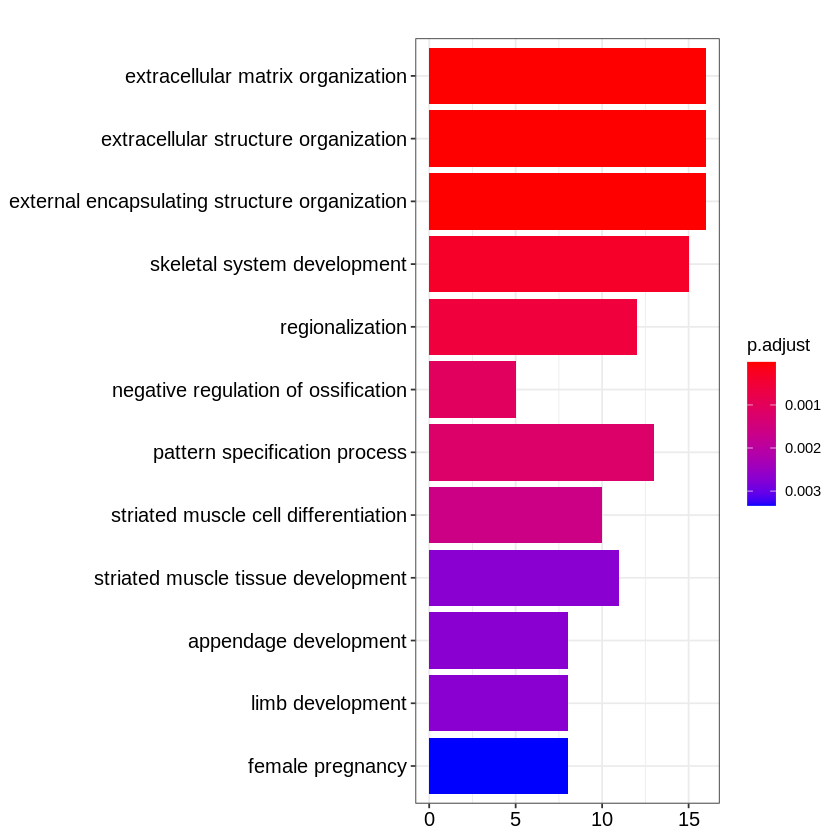

In [73]:
#ego_result.simple <- simplify(ego_rslt)
barplot(ego_rslt, drop=TRUE, showCategory=12)